# COGS 108 - Final Project 

# Overview

This project attempted to answer the question of whether income affects the amount of recreation centers and the number of amenities that these centers have within a zip code. With the use of open source data of San Diego, data analysis was done on recreation and income data for individual zip codes. In the end, no clear result was found as there was a lack of detailed and diverse data. 

# Name & GitHub ID

- Name: Michelle Duong
- GitHub Username: m4duong

# Research Question

Does the average gross income and its average per zip code within the city of San Diego affect the number of recreation centers and the amount of amenities that the zip code has? 

## Background and Prior Work

Looking through a research paper that asked if socio-economic status affect whether or not people used amenities of their community park, there was ample evidence that it did. One of the first things noted is that cities with higher rates of poverty (HP) had smaller community parks whereas cities with lower rates (LP) had larger community parks (#1, Table 1). Despite that, on average residents of HP cities visited their parks more often than residents of LP cities. It also seems that of the surveyed participants, there was a higher percentage of people in HP cities that would visit their park once a week or more versus people in LP cities.

Another research paper found that recreation centers in moderate/high income areas had more amenities that low income neighborhoods. Amenities included gymnasiums, activity rooms, baseball/softball fields, outdoor basketball courts, and more. The different here actualyl is not by much, however, it was also found that the conditions that these facilities were in were much better in moderate/high income areas (#2, Table 1).

I think that it's also good to note what kind of amenities a park has and how that might attract visitors. In a paper looking at park use in low-income urban neighborhoods, it was noted that were was indeed a correlation between number of amenities offered at a park or recreation center and how many visitors it attracts.

Unfortunately, I was unable to find previous work on how housing cost or average income affect how many parks or facilities there are in a given neighborhood.

References (include links):

1) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3667219/
2) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4082954/

# Hypothesis


Based off the research above, I hypothesize that a neighborhood's average income can affect the number of recreation centers and amenities that a recreation center has.

I suspect that average income will impact the amount of taxes a zip code recieves, impacting how much funding parks and recreation gets, and in turn, impacting the likelihood that there is a recreation center and the number of amenities they have. Furthermore, the data found in the second reference from the background suggests that there is a positive correlation between areas with higher income and recreation centers with more amenities.

# Dataset(s)

- Personal Income Tax Statistics By Zip Code
- https://data.ftb.ca.gov/California-Personal-Income-Tax/Personal-Income-Tax-Statistics-By-Zip-Code/mriu-wsxf
- 63866

This data set is found on a public government website and shows anonymous tax information. The columns that will be used are the year, zip code, returns, and adjusted gross income. The adjusted gross income is a total sum for the given year and zip code.

- San Diego County Maps and Geographical Resources
- https://data.sandiegocounty.gov/Maps-and-Geographical-Resources/Zip-Codes/vsuf-uefy
- 122

This data set is found on a public government website and provides zip code and geometry data for the county of San Diego. This data will be essential to provide a visual representation of the San Diego area.

- Recreation Center Points
- https://data.sandiego.gov/datasets/recreation-center-locations/
- 57

This data set is found on a public government website and provides the zip code, amenities offered, and geometry for all the recreation centers in the city of San Diego. This data set was also provided by the professor.

It is essential to use all three data sets together. The tax statistics data set is needed for the income information, the recreation center provides the needed amentities information, and the maps data allows for geospatial analysis.

# Setup

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl

from shapely import wkt
import seaborn as sns

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

In [2]:
# import data
df2 = gpd.read_file('rec_centers_datasd.geojson')
df4 = gpd.read_file('Zip-Codes.geojson')
df7 = pd.read_csv('Personal_Income_Tax_Statistics_By_Zip_Code.csv')

# Data Cleaning

Start off by printing all the columns to view them. From df2, I removed everything except for the amenities, zip, sq_ft, and geometry. They are all important data. For df4 I removed shape data because the geometry is adequate for the work I am doing. Lastly for d7, I only kept the zip code, returns, CA AGI, and the 2018 taxable year.

In [3]:
#- Look through columns to see what should be kept
print(df2.columns)
print(df4.columns)
print(df7.columns)

Index(['objectid', 'rec_bldg', 'park_name', 'address', 'zip', 'sq_ft',
       'year_built', 'serv_dist', 'adult_ctr', 'comfort_st', 'comp_rm',
       'dance_rm', 'game_rm', 'gymnasium', 'kiln', 'kiln_rm', 'kitchen',
       'multp_rm', 'racqb_ct', 'stage', 'teen_ctr', 'tinytot_rm', 'weight_rm',
       'current_cd', 'fy13_cd', 'facility_n', 'thomas_bro', 'community',
       'geometry'],
      dtype='object')
Index(['community', 'shape_star', 'shape_stle', 'zip', 'geometry'], dtype='object')
Index(['Taxable Year', 'Zip Code', 'State', 'City', 'County', 'Returns',
       'CA AGI', 'Total Tax Liability', 'CountyLatitude', 'CountyLongitude',
       'Geo County', 'Geo City', 'Geo ZipCode'],
      dtype='object')


In [4]:
#- Drop columns and rows that aren't needed
df2 = df2.drop(["objectid", "rec_bldg", "park_name",
                "address", "year_built", "serv_dist",
                "fy13_cd", "facility_n", "thomas_bro",
                "current_cd", "community"],
                axis = 1)
df4 = df4.drop(["shape_star", "shape_stle"], axis = 1)
df7 = df7.drop(["State", "CountyLatitude", "CountyLongitude",
                "Geo County", "Geo City", "Geo ZipCode", 'City', 'County', 'Total Tax Liability'],
                axis = 1)
df7.drop(df7[df7['Taxable Year'] != 2018].index, inplace = True)
df2 = df2.reset_index(drop=True)
df4 = df4.reset_index(drop=True)
df7 = df7.reset_index(drop=True)

After the data sets are trimmed down, there is additional data that I must process, such as the mean income for each zip code. Also, there is disagreement between the different data sets about what zip codes belong to San Diego. I ended up just using all of the zip codes in San Diego county to display the map and then when it came to the recreation center data I referenced the tax statistics data set.

Three main steps here:
1. I had to add the adjusted gross income(AGI) and return data to the San Diego county map data set. In addition I had to calculate the mean income per zip code and add that to the map data set as well. I used nested loops to match up the zip codes from the map data set to the tax data set, withdrew the AGI and return values, added it to its own list, and then added the lists to the map data set. This allows for easier map visual.

2. The recreation data set lists out all the amenities that they do and do not offer and this is standardized throughout San Diego. I simply created a new list that summed up the number of amenities.

3. Similar to the first step, but this is for the individual recreation centers and their zip codes. This way graphing the income data with amenities count is easier.

What was difficult about these three data sets, besides their zip code discrepency, is that they are all different sizes. I essentially had a very large data set, a medium sized data set, and a small data set. With how each had their own specialized data, it is not practical nor possible to merge them to make a single dataframe for use here. My goal here was to make it so that the map data set and the recreation center data set could work autonomously when their data is needed. For example, if I needed to create a map of San Diego, I only want to be using the map data set, even if I need income data. To do this, the income data set was only used for extracting information into the other two.

In [5]:
#- 1 Assign tax data to df4 (zip code data) from df7 (tax data) and calculate mean_income
income = []
mean_inc = []

for i in df4.index:
    counter = 0
    for j in df7.index:
        if df4.at[i, 'zip'] == df7.at[j, 'Zip Code']:
            income.append(int(df7.at[j, 'CA AGI']))
            mean_inc.append(int(df7.at[j, 'CA AGI']) / int(df7.at[j, 'Returns']))
            counter = 1
    if counter == 0:
        income.append(0)
        mean_inc.append(0)

df4.insert(3, 'income', income)
df4.insert(4, 'mean_inc', mean_inc)

In [6]:
#- 2 Finding total number of ammenities that each rec center has
perks = []
amenities = df2
amenities = amenities.drop(['zip', 'sq_ft', 'kiln', 'geometry'], axis = 1)

for i in amenities.index:
    perks.append(sum(amenities.loc[i,:]))

df2.insert(4, "amenities", perks)


In [7]:
#- 3 Assigning adjusted gross income data to rec center data frame
zip_agi = []
zip_mean_inc = []

for i in df2.index:
    for j in df7.index:
        if str(df2.at[i, 'zip']) == df7.at[j, 'Zip Code']:
            zip_agi.append(int(df7.at[j, 'CA AGI']))
            zip_mean_inc.append(int(df7.at[j, 'CA AGI']) / int(df7.at[j, 'Returns']))
            break

df2.insert(5, "zip_AGI", zip_agi)
df2.insert(6, "mean_income", zip_mean_inc)

# Data Analysis and Results

For the data analysis, I first create two heat maps of San Diego county. The first map has the AGI data dispalyed per zip code and the second one has mean income data dispalyed per zip code. I wanted to first make a prediction with these maps. From my hypothesis I said that moderate/high income areas would have the most amenities and more likely have a recreation center. So for the first two maps I will make my predictions where the recreation centers will be.

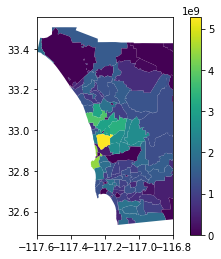

In [8]:
#- Heat map of SD with adjusted gross income per zipcode 
max_inc = max(df4.loc[:,'income'])
min_inc = min(df4.loc[:,'income'])
fig, ax = plt.subplots(1)

bar = plt.cm.ScalarMappable(norm = plt.Normalize(vmin = min_inc, vmax = max_inc))
cbar = fig.colorbar(bar)
df4.plot('income', ax = ax)
plt.xlim([-117.6, -116.8])

plt.show()

#credit to Mukund Vemuri for his guide on how to make heat maps
#https://medium.com/@m_vemuri/create-a-geographic-heat-map-of-the-city-of-toronto-in-python-cd2ae0f8be55

# figure 1

The figure above is a heat map of San Diego with the bar on the right indicating the AGI of the zip code. From this, I suspect that there will be more recreation centers within that lighter cluster in the middle, surrounding the yellow area.

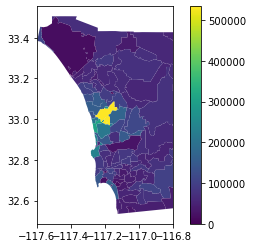

In [9]:
#-Heat map of SD with mean_income per zip code based off of number of returns and adjusted gross income
max_inc = max(df4.loc[:,'mean_inc'])
min_inc = min(df4.loc[:,'mean_inc'])
fig, ax = plt.subplots(1)

bar = plt.cm.ScalarMappable(norm = plt.Normalize(vmin = min_inc, vmax = max_inc))
cbar = fig.colorbar(bar)
df4.plot('mean_inc', ax = ax)
plt.xlim([-117.6, -116.8])
plt.show()
#credit to Mukund Vemuri for his guide on how to make heat maps
#https://medium.com/@m_vemuri/create-a-geographic-heat-map-of-the-city-of-toronto-in-python-cd2ae0f8be55

# figure 2
The figure above is a heat map of San Diego with the bar on the right indicating the mean income of the zip code. From this, I suspect that there will be more recreation centers within that lighter cluster in the middle, below and including the yellow area.


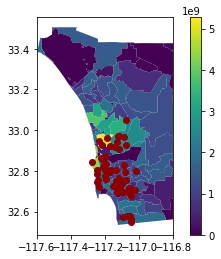

In [10]:
# Graph of park locations over adjusted gross income
max_inc = max(df4.loc[:,'income'])
min_inc = min(df4.loc[:,'income'])
fig, ax = plt.subplots(1)

bar = plt.cm.ScalarMappable(norm = plt.Normalize(vmin = min_inc, vmax = max_inc))
cbar = fig.colorbar(bar)
df4.plot('income', ax = ax)
df2.plot(ax = ax, color = 'darkred')
plt.xlim([-117.6, -116.8])
plt.show()

# figure 3
Above is the same chart as figure 1, except the red circles indicate where the recreation centers are located. My assumption was mostly incorrect as there are some recreation centers within the yellow area, but the majority are below it in the darker blue section.


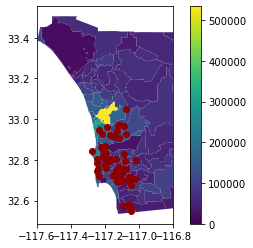

In [11]:
#- Graph of park locations over mean_income
max_inc = max(df4.loc[:,'mean_inc'])
min_inc = min(df4.loc[:,'mean_inc'])
fig, ax = plt.subplots(1)

bar = plt.cm.ScalarMappable(norm = plt.Normalize(vmin = min_inc, vmax = max_inc))
cbar = fig.colorbar(bar)
df4.plot('mean_inc', ax = ax)
df2.plot(ax = ax, color = 'darkred')
plt.xlim([-117.6, -116.8])
plt.show()

# figure 4
Above is the same chart as figure 2, except the red circles indicate where the recreation centers are located. My assumption was mostly incorrect as there is only 1 recreation center within the yellow area and the majority are below it in the more purple areas.

Text(0.5, 0, 'Mean Income')

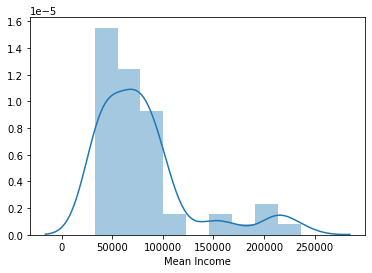

In [21]:
sns.distplot(df2.loc[:,'mean_income'])
plt.xlabel('Mean Income')

# figure 5
Distribution plot of the mean income data for all the zip codes with a recreation center. This shows a right skewed distribution.

Text(0.5, 0, 'Adjusted Growth Income ')

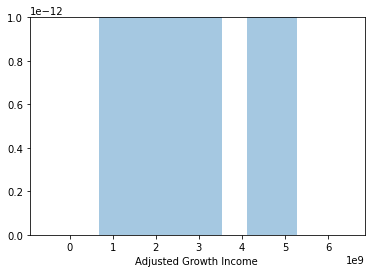

In [22]:
sns.distplot(df2.loc[:,'zip_AGI'])
plt.xlabel('Adjusted Growth Income ')

# figure 6
Distribution plot of the adjusted growth income for all the zip codes with a recreation center. There is no distribution curve.

Text(0.5, 0, 'Amenities ')

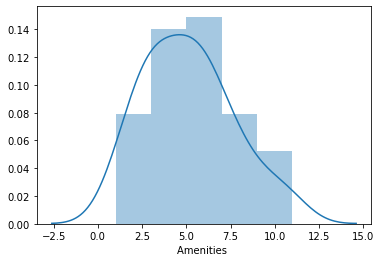

In [24]:
sns.distplot(df2.loc[:,'amenities'])
plt.xlabel('Amenities ')

# figure 7
Distribution plot of the amenities count for all the recreation centers. Very close to a bell curve, pretty even.

In [12]:
#- Create linear regression model for the number of amenities with the adjusted gross income
outcome, predictors = patsy.dmatrices('amenities ~ zip_AGI', df2)
mod = sm.OLS(outcome, predictors)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              amenities   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9571
Date:                Wed, 16 Dec 2020   Prob (F-statistic):              0.332
Time:                        23:01:24   Log-Likelihood:                -133.18
No. Observations:                  57   AIC:                             270.4
Df Residuals:                      55   BIC:                             274.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6326      0.636      8.856      0.0

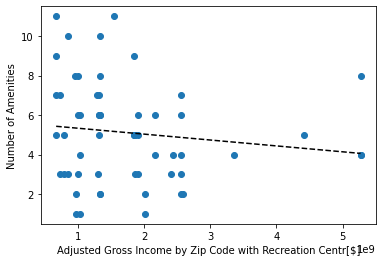

In [27]:
#- Chart of model fit line: rec center zip code adjusted gross income vs # of amenities that a rec center has
df2 = df2.sort_values(by = ['zip_AGI'])

plt.scatter(df2.loc[:, 'zip_AGI'], df2.loc[:,'amenities'])
x = df2.loc[:, 'zip_AGI']
y = -2.981e-10 * x + 5.6326
plt.plot(x, y, '--k')

plt.xlabel('Adjusted Gross Income by Zip Code with Recreation Centr[$]')
plt.ylabel('Number of Amenities')
plt.show()

# figure 8
Relationship between the number of amenities and the adjusted gross income per zip code. The amenities spread among the cluster of adjsuted gross income on the left half of the chart is wide for this data set. Essentially, data is all over the place on the left half and there is not enough data on the right half.

In [14]:
#- Create linear regression model for the number of amenities with the mean income
outcome, predictors = patsy.dmatrices('amenities ~ mean_income', df2)
mod = sm.OLS(outcome, predictors)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              amenities   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.224
Date:                Wed, 16 Dec 2020   Prob (F-statistic):              0.273
Time:                        23:01:24   Log-Likelihood:                -133.04
No. Observations:                  57   AIC:                             270.1
Df Residuals:                      55   BIC:                             274.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.7269      0.655      8.743      

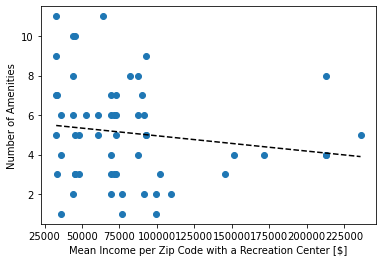

In [15]:
#- Chart of model fit line: rec center zip code mean_income vs # of amenities that a rec center has
df2 = df2.sort_values(by = ['mean_income'])

plt.scatter(df2.loc[:,'mean_income'], df2.loc[:,'amenities'])
x = df2.loc[:, 'mean_income']
y = -7.738e-6 * x + 5.7269
plt.plot(x, y, '--k')

plt.xlabel('Mean Income per Zip Code with a Recreation Center [$]')
plt.ylabel('Number of Amenities')
plt.show()

# figure 9
Relationship between the number of amenities and the mean income per zip code. The amenities spread among the the cluster of mean income is wide for this group. The average amenities definitely hovers around 5, but the mean income does not look to be a factor

# Ethics & Privacy

This project did not need or use any personal information, as it only required general information. As such the data in this project is used ethically and no one's privacy was infringed. All the data used is public domain as they can be found on government websites.

There is a potential bias in the personal income tax by zip code data. Because San Diego county has three major universities, there is a considerable amount of students renting homes in the areas near their campus. Thus, the income tax data may not be accurate if students list those homes as their address. Despite that, I believe that this issue is mitigated from the overall large number of people filing income taxes.

# Conclusion & Discussion

*Fill in your discussion information here*

This project attempted to answer the question of whether the average gross income and its average per zip code within the city of San Diego affect the number of recreation centers and the amount of amenities that the zip code has? There is no answer as the results are inconlusive. Firstly, the data found and used to do this project were limited. I was only able to find total adjusted gross income per zip code which could skew the data as the ranges between actual income could be great. Secondly, from what I was able to see(after the fact) San Diego is not a good city to do this research on. The majority of the zip codes had an average income was that well above the low income level within the second reference in the background section(#2). Essentially, all of San Diego is in the moderate/high income range which all should have more amenities. However, as you can see from figures 8 and 9, even within the same mean income ranges, the spreads between the amount of amenities the recreation centers have is wide.

What this project needed is to be conducted on a more financially diverse city or even county as well as use more detailed income data. This would allow for more accurate data analysis as the environment is more fairly balanced. I do not believe that my work here has much impact on society since all it does is confirm that moderate to high income areas do have more amenities. 